En este proyecto se plantea hacer la predicción a través de Regresión Lineal para la variable precio_arrendamiento sobre inmuebles obtenidos de la base de datos de Habi, así mismo como agrupación con Kmeans para obtener algunos insight sobre los inmuebles del negocio.

# 1.Importacion de librerías y carga de datos

In [ ]:
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from joblib import dump, load

from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer

from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import scipy.stats as stats

In [ ]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 50)

df = pd.read_csv("/content/archivo_convertido_filtrado_1000.csv")

# 2.Entendimiento de los datos

## 2.1Exploración de los datos

In [ ]:
df_dim = df.shape
print(">> El dataframe contiene " + str(df_dim[1]) + " columnas y "+ str(df_dim[0]) +" filas\n")
print(">> El dataframe se ve de la siguiente forma: ")
df.head()

>> El dataframe contiene 16 columnas y 403 filas

>> El dataframe se ve de la siguiente forma: 


,_id,precio_venta,area,habitaciones,banos,administracion,parqueaderos,sector,estrato,antiguedad,estado,precio_arriendo,vigilancia,localidad,is_cerca_estacion_tm,is_cerca_parque
0,66d86c82ceda690e85508bc6,9.000000e+08,194.0,3.0,5.0,895000.0,2.0,CERROS DE SUBA,5,MAS DE 20 ANOS,USADO,4900000.0,1,SUBA,1,0
1,66d86c83ceda690e85508d8d,2.450000e+08,54.0,3.0,2.0,189400.0,0.0,ANTONIO NARINO,3,ENTRE 10 Y 20 ANOS,USADO,850000.0,1,ANTONIO NARINO,0,1
2,66d86c85ceda690e85508f43,1.500000e+09,190.0,3.0,4.0,1645000.0,4.0,CHICO,6,ENTRE 10 Y 20 ANOS,USADO,7500000.0,1,CHAPINERO,0,1
3,66d86c85ceda690e85508f9a,1.750000e+09,220.0,3.0,5.0,NaN,4.0,COUNTRY,5,ENTRE 10 Y 20 ANOS,USADO,5500000.0,1,USAQUEN,0,0
4,66d86c86ceda690e85509056,2.600000e+09,330.0,4.0,4.0,1950000.0,2.0,COUNTRY,5,ENTRE 10 Y 20 ANOS,USADO,8000000.0,1,USAQUEN,0,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 403 entries, 0 to 402
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   _id                   403 non-null    object 
 1   precio_venta          403 non-null    float64
 2   area                  403 non-null    float64
 3   habitaciones          402 non-null    float64
 4   banos                 402 non-null    float64
 5   administracion        337 non-null    float64
 6   parqueaderos          402 non-null    float64
 7   sector                394 non-null    object 
 8   estrato               403 non-null    int64  
 9   antiguedad            401 non-null    object 
 10  estado                403 non-null    object 
 11  precio_arriendo       403 non-null    float64
 12  vigilancia            403 non-null    int64  
 13  localidad             403 non-null    object 
 14  is_cerca_estacion_tm  403 non-null    int64  
 15  is_cerca_parque       4

In [ ]:
df.dtypes

,0
_id,object
precio_venta,float64
area,float64
habitaciones,float64
banos,float64
administracion,float64
parqueaderos,float64
sector,object
estrato,int64
antiguedad,object


In [ ]:
df.localidad.value_counts()

,count
localidad,
CHAPINERO,236
USAQUEN,119
SUBA,24
ENGATIVA,5
FONTIBON,4
SANTA FE,3
KENNEDY,3
TEUSAQUILLO,3
PUENTE ARANDA,2


In [ ]:
df.sector.value_counts()

,count
sector,
CHICO,222
SANTA BARBARA,65
COUNTRY,37
CEDRITOS,12
CHAPINERO ALTO,11
CERROS DE SUBA,7
NIZA ALHAMBRA,6
ALTOS DE SUBA Y CERROS DE SAN JORGE,5
SALITRE MODELIA,5


Se evidencian 7 variables categorícas: is_cerca_parque,is_cerca_estacion_tm,vigilancia,estado,antiguedad,localidad,sector. El resto son variables en int64 o float64. Además se evidencia que se cuenta con 403 registros lo cual puede que no sea suficiente para crear un modelo con poco sesgo.

Se revisan a continuación medidas de tendencia central, medidas de desviación y otras propiedades para identificar posibles outliers.

In [ ]:
df.describe()

,precio_venta,area,habitaciones,banos,administracion,parqueaderos,estrato,precio_arriendo,vigilancia,is_cerca_estacion_tm,is_cerca_parque
count,4.030000e+02,403.000000,402.000000,402.000000,3.370000e+02,402.000000,403.000000,4.030000e+02,403.000000,403.000000,403.000000
mean,5.281297e+09,200.777990,2.853234,3.544776,5.019035e+06,2.430348,5.573201,8.401578e+07,0.568238,0.176179,0.282878
std,7.215958e+10,133.493304,0.836125,1.255108,6.857117e+07,1.038594,0.878984,9.905699e+08,0.495937,0.381446,0.450958
min,1.400000e+06,0.000000,1.000000,1.000000,9.400000e+02,0.000000,2.000000,7.400000e+05,0.000000,0.000000,0.000000
25%,6.510000e+08,106.500000,2.000000,2.000000,7.220000e+05,2.000000,5.500000,4.480000e+06,0.000000,0.000000,0.000000
50%,1.450000e+09,179.000000,3.000000,4.000000,1.100000e+06,2.000000,6.000000,7.500000e+06,1.000000,0.000000,0.000000
75%,2.386000e+09,266.500000,3.000000,5.000000,1.615000e+06,3.000000,6.000000,1.200000e+07,1.000000,0.000000,1.000000
max,1.450000e+12,1700.000000,5.000000,5.000000,1.260000e+09,4.000000,6.000000,1.800000e+10,1.000000,1.000000,1.000000


Se identifica una gran variación entre el precio de venta de los inmuebles. Existen outliers en esa variable.

<ipython-input-147-b0247466b696>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=70)


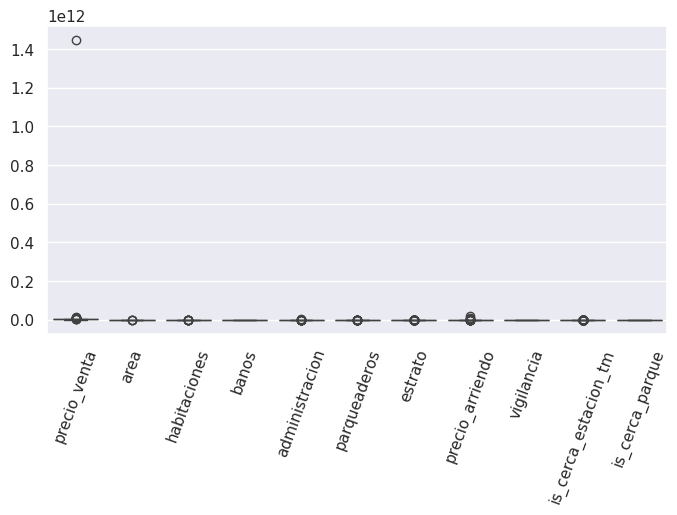

In [ ]:
df_numericas = df.select_dtypes(include=['float64', 'int64'])
fig = plt.figure(figsize=(8, 4))
ax = sns.boxplot(data=df_numericas)
ax.set_xticklabels(ax.get_xticklabels(), rotation=70)
plt.show()

En este grafico se aprecia que la variable precio de venta tiene un valor extreadamente alto, lo cual indicaría que son outliers estan y se alejan bastante del tercer cuartil. Sin embargo el resto de variables parecen bastante uniformes y cercanas a 0 por lo que son vaariables con valores muy pequeños.

## 2.2 Analisis de completitud

Ahora se verificará que no existan valores NaN.

In [ ]:
df.isna().sum()

,0
_id,0
precio_venta,0
area,0
habitaciones,1
banos,1
administracion,66
parqueaderos,1
sector,9
estrato,0
antiguedad,2


PAra solucionar el problema de administración se propone obtener la media de administración para cada estrato y depnediendo del estrato del registro se le imputara un valor.

In [ ]:
media_por_estrato = df.groupby('estrato')['administracion'].mean()

def imputar_administracion(row):
    if pd.isna(row['administracion']):
         return media_por_estrato[row['estrato']]
    else:
         return row['administracion']

df['administracion'] = df.apply(imputar_administracion, axis=1)

print("Valores faltantes en 'administracion' después de la imputación:", df['administracion'].isna().sum())
print(df.head())

Valores faltantes en 'administracion' después de la imputación: 0
                        _id  precio_venta   area  habitaciones  banos  \
0  66d86c82ceda690e85508bc6  9.000000e+08  194.0           3.0    5.0   
1  66d86c83ceda690e85508d8d  2.450000e+08   54.0           3.0    2.0   
2  66d86c85ceda690e85508f43  1.500000e+09  190.0           3.0    4.0   
3  66d86c85ceda690e85508f9a  1.750000e+09  220.0           3.0    5.0   
4  66d86c86ceda690e85509056  2.600000e+09  330.0           4.0    4.0   

   administracion  parqueaderos          sector  estrato          antiguedad  \
0    8.950000e+05           2.0  CERROS DE SUBA        5      MAS DE 20 ANOS   
1    1.894000e+05           0.0  ANTONIO NARINO        3  ENTRE 10 Y 20 ANOS   
2    1.645000e+06           4.0           CHICO        6  ENTRE 10 Y 20 ANOS   
3    8.362682e+05           4.0         COUNTRY        5  ENTRE 10 Y 20 ANOS   
4    1.950000e+06           2.0         COUNTRY        5  ENTRE 10 Y 20 ANOS   

  estado  prec

Se arreglara los nulos de banos, parqueaderos, utilizando la moda de esa columna. Sin embargo, para el caso de sector se quitaran esos registros debido a que no hay una forma para poder saber en que sector se ubica el registro.

In [ ]:
moda_banos = df['banos'].mode()[0]
df['banos'].fillna(moda_banos, inplace=True)

moda_parqueaderos = df['parqueaderos'].mode()[0]
df['parqueaderos'].fillna(moda_parqueaderos, inplace=True)

moda_habitaciones = df['habitaciones'].mode()[0]
df['habitaciones'].fillna(moda_habitaciones, inplace=True)

moda_antiguedad = df['antiguedad'].mode()[0]
df['antiguedad'].fillna(moda_antiguedad, inplace=True)

moda_sector= df['sector'].mode()[0]
df['sector'].fillna(moda_sector, inplace=True)

df = df.dropna(subset=['sector'])
df.isna().sum()

,0
_id,0
precio_venta,0
area,0
habitaciones,0
banos,0
administracion,0
parqueaderos,0
sector,0
estrato,0
antiguedad,0


## 2.3 Anlísis de unicidad

In [ ]:
duplicates = df.duplicated()
num_duplicates = duplicates.sum()
print("Number of duplicates: ", num_duplicates)

Number of duplicates:  0


No hay duplicados.

## 2.4 Analísis de validez

In [ ]:
#Value counts para cada variable númerica
print(df['precio_venta'].value_counts(),"\n")
print(df['area'].value_counts(),"\n")
print(df['banos'].value_counts(),"\n")
print(df['administracion'].value_counts(),"\n")
print(df['parqueaderos'].value_counts(),"\n")
print(df['precio_arriendo'].value_counts(),"\n")


precio_venta
1.600000e+09    13
1.500000e+09    11
1.200000e+09    10
2.300000e+09     9
1.800000e+09     8
                ..
2.500000e+08     1
3.900000e+09     1
1.959000e+09     1
4.700000e+09     1
1.490000e+09     1
Name: count, Length: 199, dtype: int64 

area
220.00    9
300.00    7
130.00    6
200.00    6
330.00    6
         ..
312.00    1
369.00    1
171.21    1
259.00    1
88.00     1
Name: count, Length: 239, dtype: int64 

banos
5.0    125
4.0     96
2.0     91
3.0     74
1.0     17
Name: count, dtype: int64 

administracion
1465561.0    44
1500000.0    19
1000000.0    17
1200000.0    13
2000000.0    13
             ..
2136200.0     1
980000.0      1
1165000.0     1
1900000.0     1
940.0         1
Name: count, Length: 174, dtype: int64 

parqueaderos
2.0    163
3.0    109
4.0     71
1.0     42
0.0     18
Name: count, dtype: int64 

precio_arriendo
8000000.0     24
12000000.0    20
5500000.0     16
15000000.0    14
7000000.0     13
              ..
1200000.0      1
9800000

In [ ]:
#value counts variables categoricas
print(df['estrato'].value_counts(),"\n")
print(df['estado'].value_counts(),"\n")
print(df['vigilancia'].value_counts(),"\n")
print(df['is_cerca_estacion_tm'].value_counts(),"\n")
print(df['is_cerca_parque'].value_counts(),"\n")
print(df['antiguedad'].value_counts(),"\n")
print(df['localidad'].value_counts(),"\n")
print(df['sector'].value_counts(),"\n")

estrato
6    302
5     58
4     22
3     14
2      7
Name: count, dtype: int64 

estado
USADO    403
Name: count, dtype: int64 

vigilancia
1    229
0    174
Name: count, dtype: int64 

is_cerca_estacion_tm
0    332
1     71
Name: count, dtype: int64 

is_cerca_parque
0    289
1    114
Name: count, dtype: int64 

antiguedad
ENTRE 10 Y 20 ANOS    114
ENTRE 0 Y 5 ANOS       90
ENTRE 5 Y 10 ANOS      88
MAS DE 20 ANOS         86
REMODELADO             25
Name: count, dtype: int64 

localidad
CHAPINERO         236
USAQUEN           119
SUBA               24
ENGATIVA            5
FONTIBON            4
SANTA FE            3
KENNEDY             3
TEUSAQUILLO         3
PUENTE ARANDA       2
ANTONIO NARINO      1
TUNJUELITO          1
CIUDAD BOLIVAR      1
BOSA                1
Name: count, dtype: int64 

sector
CHICO                                  231
SANTA BARBARA                           65
COUNTRY                                 37
CEDRITOS                                12
CHAPINERO ALT

No hay errores de validez en los datos. Todos los datos son congruentes con los estableidos en el diccionario de datos.

## 2.5 Analiísis de consistencia

In [ ]:
df.dtypes

,0
_id,object
precio_venta,float64
area,float64
habitaciones,float64
banos,float64
administracion,float64
parqueaderos,float64
sector,object
estrato,int64
antiguedad,object


Todos los valores son consistentes con los domions establecidos.

# 3.Preparación de datos

## 3.1 Eliminación de outliers

Se procede a quitar outliers que sesgan el modelo usano el Rango Intercuartilico. PAra este caso se eliminaran los outliers en las dos variables que se presentan 'precio_venta', 'precio_arriendo' y aréa pues hay unas pocas propiedades con un área demasiado grande.

In [ ]:
df_filtrado=df.copy()
columnas_outliers = ['precio_venta', 'precio_arriendo','area','administracion']

Q1 = df_filtrado[columnas_outliers].quantile(0.25)
Q3 = df_filtrado[columnas_outliers].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

for col in columnas_outliers:
    median_value = df_filtrado[col].median()
    df_filtrado[col] = df_filtrado[col].mask((df_filtrado[col] < lower_bound[col]) | (df_filtrado[col] > upper_bound[col]), median_value)
df_filtrado[columnas_outliers].head()


,precio_venta,precio_arriendo,area,administracion
0,9.000000e+08,4900000.0,194.0,8.950000e+05
1,2.450000e+08,850000.0,54.0,1.894000e+05
2,1.500000e+09,7500000.0,190.0,1.645000e+06
3,1.750000e+09,5500000.0,220.0,8.362682e+05
4,2.600000e+09,8000000.0,330.0,1.950000e+06


## 3.2 Codificación variables Categoricas

Debido a que la Regresión Lineal no puede usar variables que no sean númericas se procede a realizar una codificacion con dummies para las variables categoricas que no estan en formato numerico. Esta codificación crea columnas extra e indica 1 si pertenece a la categoria o 0 de lo contraio.

In [ ]:

from sklearn.preprocessing import LabelEncoder
variables_categoricas = ['estado', 'antiguedad','sector','localidad']

df_filtrado_encoded = df_filtrado.copy()

variables_categoricas = ['estado', 'antiguedad', 'sector', 'localidad']
label_encoders = {col: LabelEncoder() for col in variables_categoricas}

for col in variables_categoricas:
    df_filtrado_encoded[col + '_encoded'] = label_encoders[col].fit_transform(df_filtrado_encoded[col])

df_filtrado = pd.concat([df_filtrado_encoded], axis=1)

# Eliminar las columnas categóricas originales
df_filtrado.drop(columns=variables_categoricas, inplace=True)
df_filtrado.head()


,_id,precio_venta,area,habitaciones,banos,administracion,parqueaderos,estrato,precio_arriendo,vigilancia,is_cerca_estacion_tm,is_cerca_parque,estado_encoded,antiguedad_encoded,sector_encoded,localidad_encoded
0,66d86c82ceda690e85508bc6,9.000000e+08,194.0,3.0,5.0,8.950000e+05,2.0,5,4900000.0,1,1,0,0,3,5,9
1,66d86c83ceda690e85508d8d,2.450000e+08,54.0,3.0,2.0,1.894000e+05,0.0,3,850000.0,1,0,1,0,1,1,0
2,66d86c85ceda690e85508f43,1.500000e+09,190.0,3.0,4.0,1.645000e+06,4.0,6,7500000.0,1,0,1,0,1,7,2
3,66d86c85ceda690e85508f9a,1.750000e+09,220.0,3.0,5.0,8.362682e+05,4.0,5,5500000.0,1,0,0,0,1,10,12
4,66d86c86ceda690e85509056,2.600000e+09,330.0,4.0,4.0,1.950000e+06,2.0,5,8000000.0,1,0,0,0,1,10,12


Como se evidencia ya no hay variables categoricas en texto.

El id no nos aporta nada se elimina.

In [ ]:
#eliminar variable sectory localidad
df_filtrado.drop(columns=['_id'], inplace=True)
df_filtrado.head()

,precio_venta,area,habitaciones,banos,administracion,parqueaderos,estrato,precio_arriendo,vigilancia,is_cerca_estacion_tm,is_cerca_parque,estado_encoded,antiguedad_encoded,sector_encoded,localidad_encoded
0,9.000000e+08,194.0,3.0,5.0,8.950000e+05,2.0,5,4900000.0,1,1,0,0,3,5,9
1,2.450000e+08,54.0,3.0,2.0,1.894000e+05,0.0,3,850000.0,1,0,1,0,1,1,0
2,1.500000e+09,190.0,3.0,4.0,1.645000e+06,4.0,6,7500000.0,1,0,1,0,1,7,2
3,1.750000e+09,220.0,3.0,5.0,8.362682e+05,4.0,5,5500000.0,1,0,0,0,1,10,12
4,2.600000e+09,330.0,4.0,4.0,1.950000e+06,2.0,5,8000000.0,1,0,0,0,1,10,12


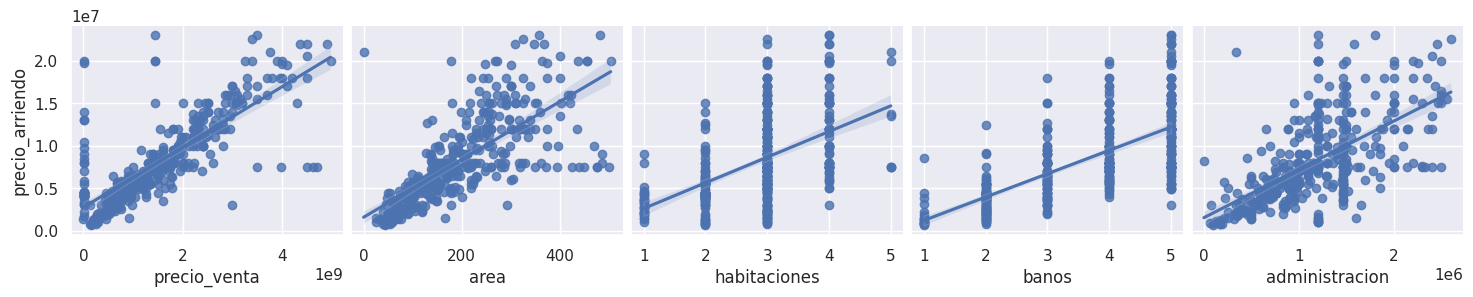

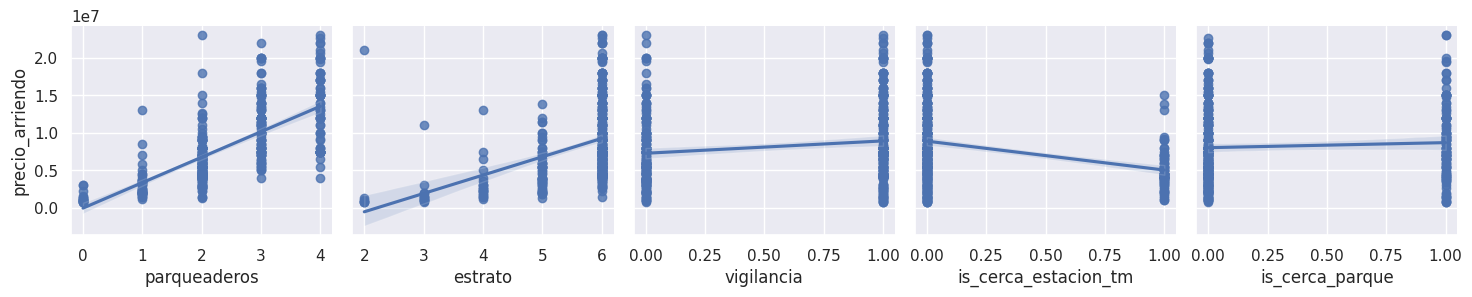

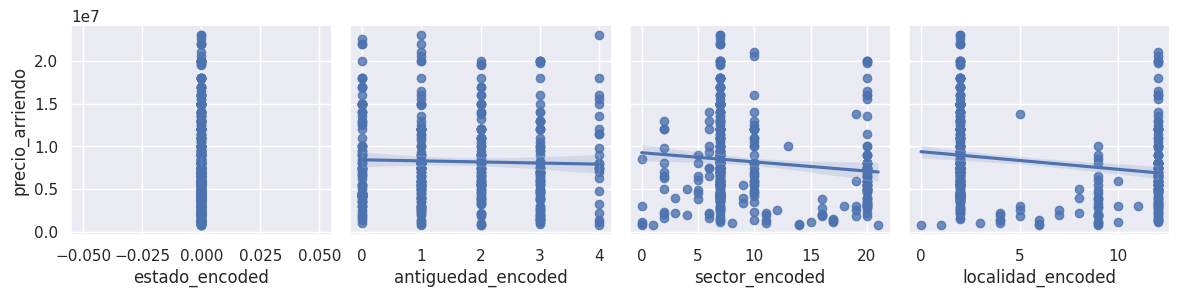

In [ ]:
# Correlacion lineal entre las variables en un heatmap

objective = "precio_arriendo"

# Features = todas las columnas menos la objetivo
features = df_filtrado.columns.tolist()
features.remove(objective)

# Una grafica de scatter con maximo 5 graficas por fila
n = 5
row_groups= [features[i:i+n] for i in range(0, len(features), n) ]

for i in row_groups:
    pp = sns.pairplot(data=df_filtrado, y_vars=[objective],x_vars=i, kind="reg", height=3)

Se evidencia que ahora hay relaciones mas coherente y con mayor correlación. En este caso son las siguientes precio_venta,area y administración. Con el resto de columnas vemos que no hay un cambio significativo en el correlacionamiento como para ser consideradas buenas columnas candidatas.

# 4.Elección de feautures

A coninuación se evalua la columna objetivo con las posibles variables a usar en el modelo.

In [ ]:
df_filtrado.columns.values

array(['precio_venta', 'area', 'habitaciones', 'banos', 'administracion',
       'parqueaderos', 'estrato', 'precio_arriendo', 'vigilancia',
       'is_cerca_estacion_tm', 'is_cerca_parque', 'estado_encoded',
       'antiguedad_encoded', 'sector_encoded', 'localidad_encoded'],
      dtype=object)

In [ ]:
objetivo = ['precio_arriendo']

features = ['precio_venta', 'area', 'habitaciones', 'banos', 'administracion',
       'parqueaderos', 'estrato', 'vigilancia','precio_arriendo','is_cerca_estacion_tm', 'is_cerca_parque', 'estado_encoded',
       'antiguedad_encoded', 'sector_encoded', 'localidad_encoded']


Se procede a realizar el Heatmap de las variables para determinar su correlación.

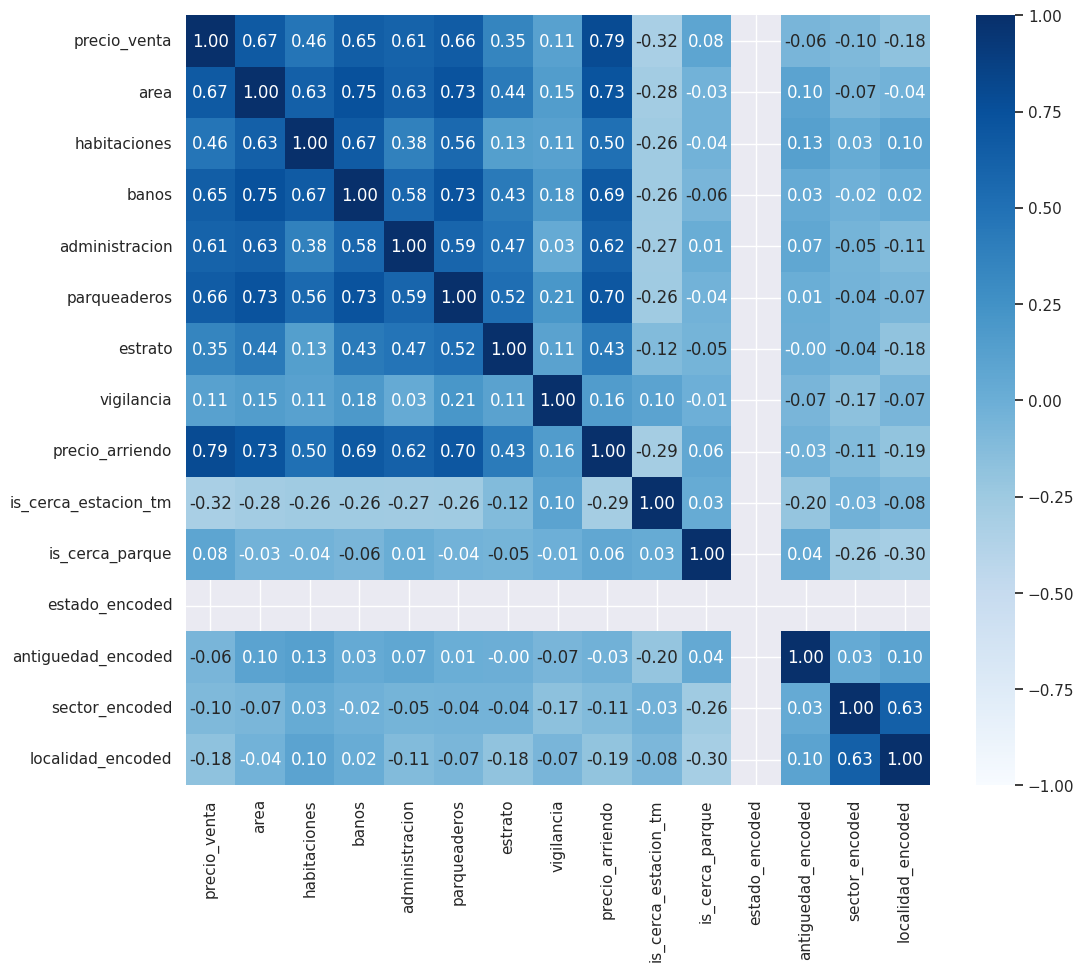

In [ ]:
plt.figure(figsize=(12, 10))
sns.heatmap(df_filtrado[features].corr(), cmap="Blues", vmin=-1, vmax=1, annot=True, fmt=".2f")
plt.show()

Vemos que hay ciertas variables con signo negativo, no se tendran en cuenta pues indica que tienen una relación inversa.
Para esgoer entre las variables tendremos que elegir las que tengan correlaciones menos a 0.8 aproximadamente. Se escoge: 'precio_venta', 'area', 'habitaciones', 'banos', 'administracion', 'parqueaderos','estrato','sector'.

In [ ]:
# Definir el umbral de correlación (por ejemplo, 0.5)
umbral = 0.5

# Calcular la matriz de correlación
correlation_matrix = df_filtrado.corr()

# Obtener las correlaciones de 'precio_arriendo' con todas las demás variables
correlaciones_objetivo = correlation_matrix['precio_arriendo'].abs()

# Seleccionar las variables que tienen una correlación mayor al umbral con 'precio_arriendo'
variables_relevantes = correlaciones_objetivo[correlaciones_objetivo > umbral].index.tolist()

# Eliminar la columna objetivo 'precio_arriendo' de la lista
variables_relevantes.remove('precio_arriendo')

# Mostrar las variables seleccionadas
print("Variables seleccionadas:", variables_relevantes)


Variables seleccionadas: ['precio_venta', 'area', 'habitaciones', 'banos', 'administracion', 'parqueaderos']


# 5.Modelo de Regresión Lineal

In [ ]:
features1=['precio_venta', 'area', 'habitaciones', 'banos', 'administracion', 'parqueaderos','estrato','sector_encoded','localidad_encoded']

In [ ]:
# Se realiza la división entrenamiento - test. Se deja 20% de los datos para el test.
X = df_filtrado[features1]
Y = df_filtrado['precio_arriendo']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=77)


Se procede a escalar usando StandardScaler para las variables precio_venta y administración ya que tienen valores demasiado altos respecto al resto y por tanto vale la pena escalarlos para tener un modelo mas austado. El resto de variables ya son suficientemente pequeñas. Se realiza en esta fase de creacion del modelo para no introducir sesgos sobre el algoritmo de regresión lineal.

In [ ]:
from sklearn.preprocessing import StandardScaler
numericas = ['precio_venta', 'area', 'habitaciones', 'banos', 'administracion', 'parqueaderos']
scaler = StandardScaler()
X_train[numericas] = scaler.fit_transform(X_train[numericas])
X_test[numericas] = scaler.transform(X_test[numericas])


In [ ]:
regression = LinearRegression()
regression.fit(X_train, Y_train)

LinearRegression()

In [ ]:
y_pred = regression.predict(X_train)

In [ ]:
regression.intercept_

7214037.286712184

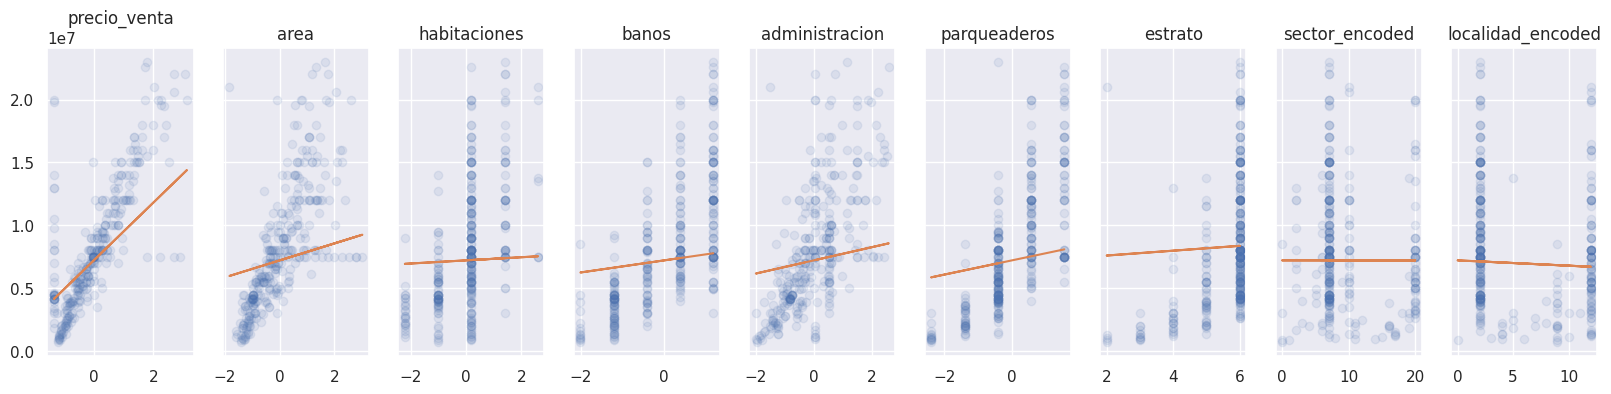

In [ ]:
f, axs = plt.subplots(1, len(features1), sharey=True, figsize=(20, 4))

for i in range(len(features1)):
    col = features1[i]
    x = X_train[col]
    m = regression.coef_[i]
    b = regression.intercept_

    axs[i].plot(x, Y_train, "o", alpha=0.1)
    axs[i].plot(x, x * m + b)
    axs[i].set_title(col)

**Validación del modelo**

In [ ]:
print("RMSE: %.2f" % mean_squared_error(Y_train, y_pred, squared=False))
print("MAE: %.2f" % mean_absolute_error(Y_train, y_pred))
print('R²: %.2f' % r2_score(Y_train, y_pred))

RMSE: 2504238.88
MAE: 1702104.11
R²: 0.74


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
y_testpred = regression.predict(X_test)
print("RMSE: %.2f" % mean_squared_error(Y_test, y_testpred, squared=False))
print("MAE: %.2f" % mean_absolute_error(Y_test, y_testpred))
print('R²: %.2f' % r2_score(Y_test, y_testpred))

RMSE: 3130538.68
MAE: 2085615.13
R²: 0.68


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


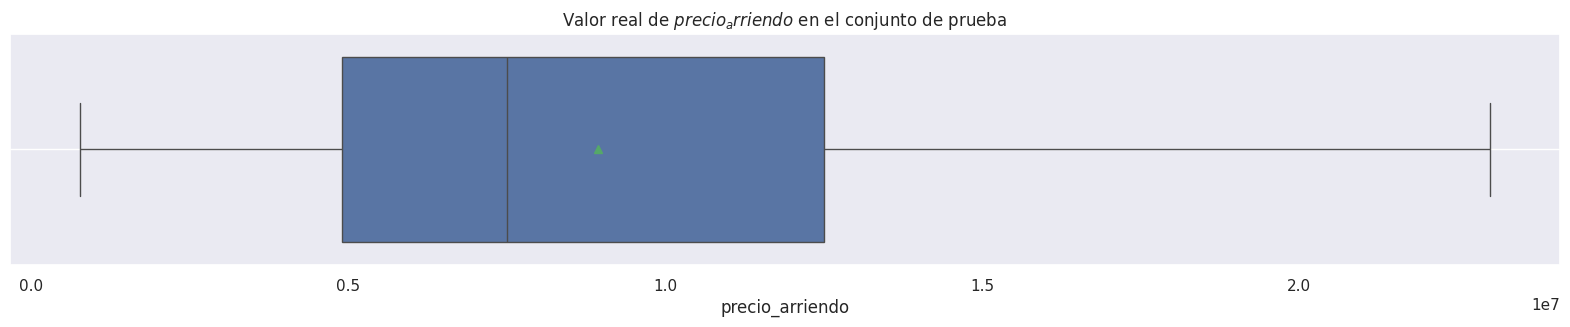

In [ ]:
plt.figure(figsize=(20, 3))
sns.boxplot(x=Y_test, showmeans=True, orient="h")
plt.title("Valor real de $precio_arriendo$ en el conjunto de prueba")
plt.grid()
plt.show()

In [ ]:
regression.score(X_test, Y_test)

0.6754194870839076

**Analisis Cuantitativo**

Como no se escalo o normalizo en ningún momento se puedo obtener información valiosa de los valores arrojados por el modelo con los datos de test.
RMSE: 3177570.64
MAE: 2125692.40
R²: 0.67

A partir del R^2 se obtiene que el modelo logra explicar el 67% de la variabilidad de los datos. El MAE nos indica que el modelo tiene un error promedio de 2125692 pesos en el valor predecido con respecto al valor real. El RMSE indica que, al penalizar más los errores grandes, en promedio, el modelo tiene un error más elevado de de 3'177570 pesos entre las predicciones y los valores reales.

Analisis Cualitativo

In [ ]:
pd.DataFrame({"columns": features1, "coef": regression.coef_})

,columns,coef
0,precio_venta,2.298712e+06
1,area,6.742457e+05
2,habitaciones,1.247638e+05
3,banos,4.795550e+05
4,administracion,5.226892e+05
5,parqueaderos,5.666738e+05
6,estrato,1.925704e+05
7,sector_encoded,-3.271541e+02
8,localidad_encoded,-4.217349e+04


In [ ]:
std_precio_venta = df_filtrado['precio_venta'].std()

# Mostrar la desviación estándar
print(f"Desviación estándar de precio_venta: {std_precio_venta}")

Desviación estándar de precio_venta: 1121895447.2277367


El intercepto de la regresión -1487970.7247993667 no tiene ningún sentido practico pues indica el valor de precio_arriendo si todas las variables fueran 0.

Los principales factores que influyen en el incremento del precio de arriendo son el precio de venta de la propiedad, el área, el número de parqueaderos, y los costos de administración. Un aumento significativo en cualquiera de estas variables, como un incremento en el precio de venta (por cada desviación estándar), puede aumentar el precio de arriendo en aproximadamente 2.3 millones de pesos, mientras que más área, parqueaderos, y mayores costos de administración también tienen impactos considerables, con aumentos que van desde 500 mil hasta 670 mil pesos. El estrato socioeconómico también incrementa el precio, aunque en menor medida. Por otro lado, el sector tiene un efecto muy pequeño y el código de localidad tiende a reducir el precio en ciertas áreas, aunque no con tanta fuerza como las variables más influyentes.

Finalmente se identifica que no existe una correlacion fuerte entre los datos suministrados para provisionar un modelo de regresion lineal que pueda retornar valores de corrimiento lo suficientemente acertados como para ser usados por la compañia.

Por lo que no se recomienda este modelo de regresion lineal para el negocio si se busca tener una presicion alta respecto a este valor. En caso contrario, se podria reevaluar el uso de este modelo.

Finalmente, es importante recalcar que los valores de parqueadero baños, sector, y precio de venta son valores para determinar el precio_arrendamiento.

# Ejercicio pero con agrupación

In [ ]:
df_agrupacion=df.copy()
df_agrupacion.head()

,_id,precio_venta,area,habitaciones,banos,administracion,parqueaderos,sector,estrato,antiguedad,estado,precio_arriendo,vigilancia,localidad,is_cerca_estacion_tm,is_cerca_parque
0,66d86c82ceda690e85508bc6,9.000000e+08,194.0,3.0,5.0,8.950000e+05,2.0,CERROS DE SUBA,5,MAS DE 20 ANOS,USADO,4900000.0,1,SUBA,1,0
1,66d86c83ceda690e85508d8d,2.450000e+08,54.0,3.0,2.0,1.894000e+05,0.0,ANTONIO NARINO,3,ENTRE 10 Y 20 ANOS,USADO,850000.0,1,ANTONIO NARINO,0,1
2,66d86c85ceda690e85508f43,1.500000e+09,190.0,3.0,4.0,1.645000e+06,4.0,CHICO,6,ENTRE 10 Y 20 ANOS,USADO,7500000.0,1,CHAPINERO,0,1
3,66d86c85ceda690e85508f9a,1.750000e+09,220.0,3.0,5.0,8.362682e+05,4.0,COUNTRY,5,ENTRE 10 Y 20 ANOS,USADO,5500000.0,1,USAQUEN,0,0
4,66d86c86ceda690e85509056,2.600000e+09,330.0,4.0,4.0,1.950000e+06,2.0,COUNTRY,5,ENTRE 10 Y 20 ANOS,USADO,8000000.0,1,USAQUEN,0,0


In [ ]:
df_agrupacion.drop(columns=['_id'], inplace=True)
df_agrupacion.head()

,precio_venta,area,habitaciones,banos,administracion,parqueaderos,sector,estrato,antiguedad,estado,precio_arriendo,vigilancia,localidad,is_cerca_estacion_tm,is_cerca_parque
0,9.000000e+08,194.0,3.0,5.0,8.950000e+05,2.0,CERROS DE SUBA,5,MAS DE 20 ANOS,USADO,4900000.0,1,SUBA,1,0
1,2.450000e+08,54.0,3.0,2.0,1.894000e+05,0.0,ANTONIO NARINO,3,ENTRE 10 Y 20 ANOS,USADO,850000.0,1,ANTONIO NARINO,0,1
2,1.500000e+09,190.0,3.0,4.0,1.645000e+06,4.0,CHICO,6,ENTRE 10 Y 20 ANOS,USADO,7500000.0,1,CHAPINERO,0,1
3,1.750000e+09,220.0,3.0,5.0,8.362682e+05,4.0,COUNTRY,5,ENTRE 10 Y 20 ANOS,USADO,5500000.0,1,USAQUEN,0,0
4,2.600000e+09,330.0,4.0,4.0,1.950000e+06,2.0,COUNTRY,5,ENTRE 10 Y 20 ANOS,USADO,8000000.0,1,USAQUEN,0,0


Se procede a realizar la normalización de los datos empleando un RobustScaler para la columna de Duración de Estancia Mínima, esto debido a que es más útil cuando se tienen valores de outliers significativos. En este caso, aunque ya se han eliminado outliers, la columna sigue teniendo datos visiblemente atípicos respecto a la media y el rango intercuartílico.

In [ ]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
variables_escalar = ['precio_venta','administracion', 'precio_arriendo','area']
df_agrupacion[variables_escalar] = scaler.fit_transform(df_agrupacion[variables_escalar])
df_agrupacion.head()

,precio_venta,area,habitaciones,banos,administracion,parqueaderos,sector,estrato,antiguedad,estado,precio_arriendo,vigilancia,localidad,is_cerca_estacion_tm,is_cerca_parque
0,-0.317003,0.09375,3.0,5.0,-0.401580,2.0,CERROS DE SUBA,5,MAS DE 20 ANOS,USADO,-0.345745,1,SUBA,1,0
1,-0.694524,-0.78125,3.0,2.0,-1.330612,0.0,ANTONIO NARINO,3,ENTRE 10 Y 20 ANOS,USADO,-0.884309,1,ANTONIO NARINO,0,1
2,0.028818,0.06875,3.0,4.0,0.585912,4.0,CHICO,6,ENTRE 10 Y 20 ANOS,USADO,0.000000,1,CHAPINERO,0,1
3,0.172911,0.25625,3.0,5.0,-0.478910,4.0,COUNTRY,5,ENTRE 10 Y 20 ANOS,USADO,-0.265957,1,USAQUEN,0,0
4,0.662824,0.94375,4.0,4.0,0.987492,2.0,COUNTRY,5,ENTRE 10 Y 20 ANOS,USADO,0.066489,1,USAQUEN,0,0


Se le hace OneHot encoder a las variables que según el diccionario se consideran relevantes.

In [ ]:
from sklearn.preprocessing import OneHotEncoder
# Seleccionamos las columnas que queremos codificar
columns_to_encode = ['antiguedad','estrato','estado']

# Inicializamos el OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)
# Aplicamos el encoder
encoded_cols = encoder.fit_transform(df_agrupacion[columns_to_encode])

# Creamos un DataFrame con las columnas codificadas
encoded_df = pd.DataFrame(encoded_cols, columns=encoder.get_feature_names_out(columns_to_encode))

,precio_venta,area,habitaciones,banos,administracion,parqueaderos,sector,estrato,antiguedad,estado,precio_arriendo,vigilancia,localidad,is_cerca_estacion_tm,is_cerca_parque
0,-0.317003,0.09375,3.0,5.0,-0.401580,2.0,CERROS DE SUBA,5,MAS DE 20 ANOS,USADO,-0.345745,1,SUBA,1,0
1,-0.694524,-0.78125,3.0,2.0,-1.330612,0.0,ANTONIO NARINO,3,ENTRE 10 Y 20 ANOS,USADO,-0.884309,1,ANTONIO NARINO,0,1
2,0.028818,0.06875,3.0,4.0,0.585912,4.0,CHICO,6,ENTRE 10 Y 20 ANOS,USADO,0.000000,1,CHAPINERO,0,1
3,0.172911,0.25625,3.0,5.0,-0.478910,4.0,COUNTRY,5,ENTRE 10 Y 20 ANOS,USADO,-0.265957,1,USAQUEN,0,0
4,0.662824,0.94375,4.0,4.0,0.987492,2.0,COUNTRY,5,ENTRE 10 Y 20 ANOS,USADO,0.066489,1,USAQUEN,0,0


In [ ]:
df_agrupacion = pd.concat([df_agrupacion, encoded_df], axis=1)
df_agrupacion.drop(columns=columns_to_encode, inplace=True)
df_agrupacion.head()

,precio_venta,area,habitaciones,banos,administracion,parqueaderos,sector,precio_arriendo,vigilancia,localidad,is_cerca_estacion_tm,is_cerca_parque,antiguedad_ENTRE 0 Y 5 ANOS,antiguedad_ENTRE 10 Y 20 ANOS,antiguedad_ENTRE 5 Y 10 ANOS,antiguedad_MAS DE 20 ANOS,antiguedad_REMODELADO,estrato_2,estrato_3,estrato_4,estrato_5,estrato_6,estado_USADO
0,-0.317003,0.09375,3.0,5.0,-0.401580,2.0,CERROS DE SUBA,-0.345745,1,SUBA,1,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,-0.694524,-0.78125,3.0,2.0,-1.330612,0.0,ANTONIO NARINO,-0.884309,1,ANTONIO NARINO,0,1,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,0.028818,0.06875,3.0,4.0,0.585912,4.0,CHICO,0.000000,1,CHAPINERO,0,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
3,0.172911,0.25625,3.0,5.0,-0.478910,4.0,COUNTRY,-0.265957,1,USAQUEN,0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,0.662824,0.94375,4.0,4.0,0.987492,2.0,COUNTRY,0.066489,1,USAQUEN,0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [ ]:
# Definir una función para eliminar outliers usando el método del Rango Intercuartílico (IQR)
def eliminar_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Aplicar la función para las columnas que desees eliminar outliers
columnas_a_filtrar = ['precio_venta', 'area', 'habitaciones', 'banos', 'administracion', 'parqueaderos', 'precio_arriendo']

# Eliminar outliers para cada una de las columnas numéricas en el DataFrame df_agrupacion
for col in columnas_a_filtrar:
    df_agrupacion = eliminar_outliers_iqr(df_agrupacion, col)



>> Se visualizan los datos normalizados: 


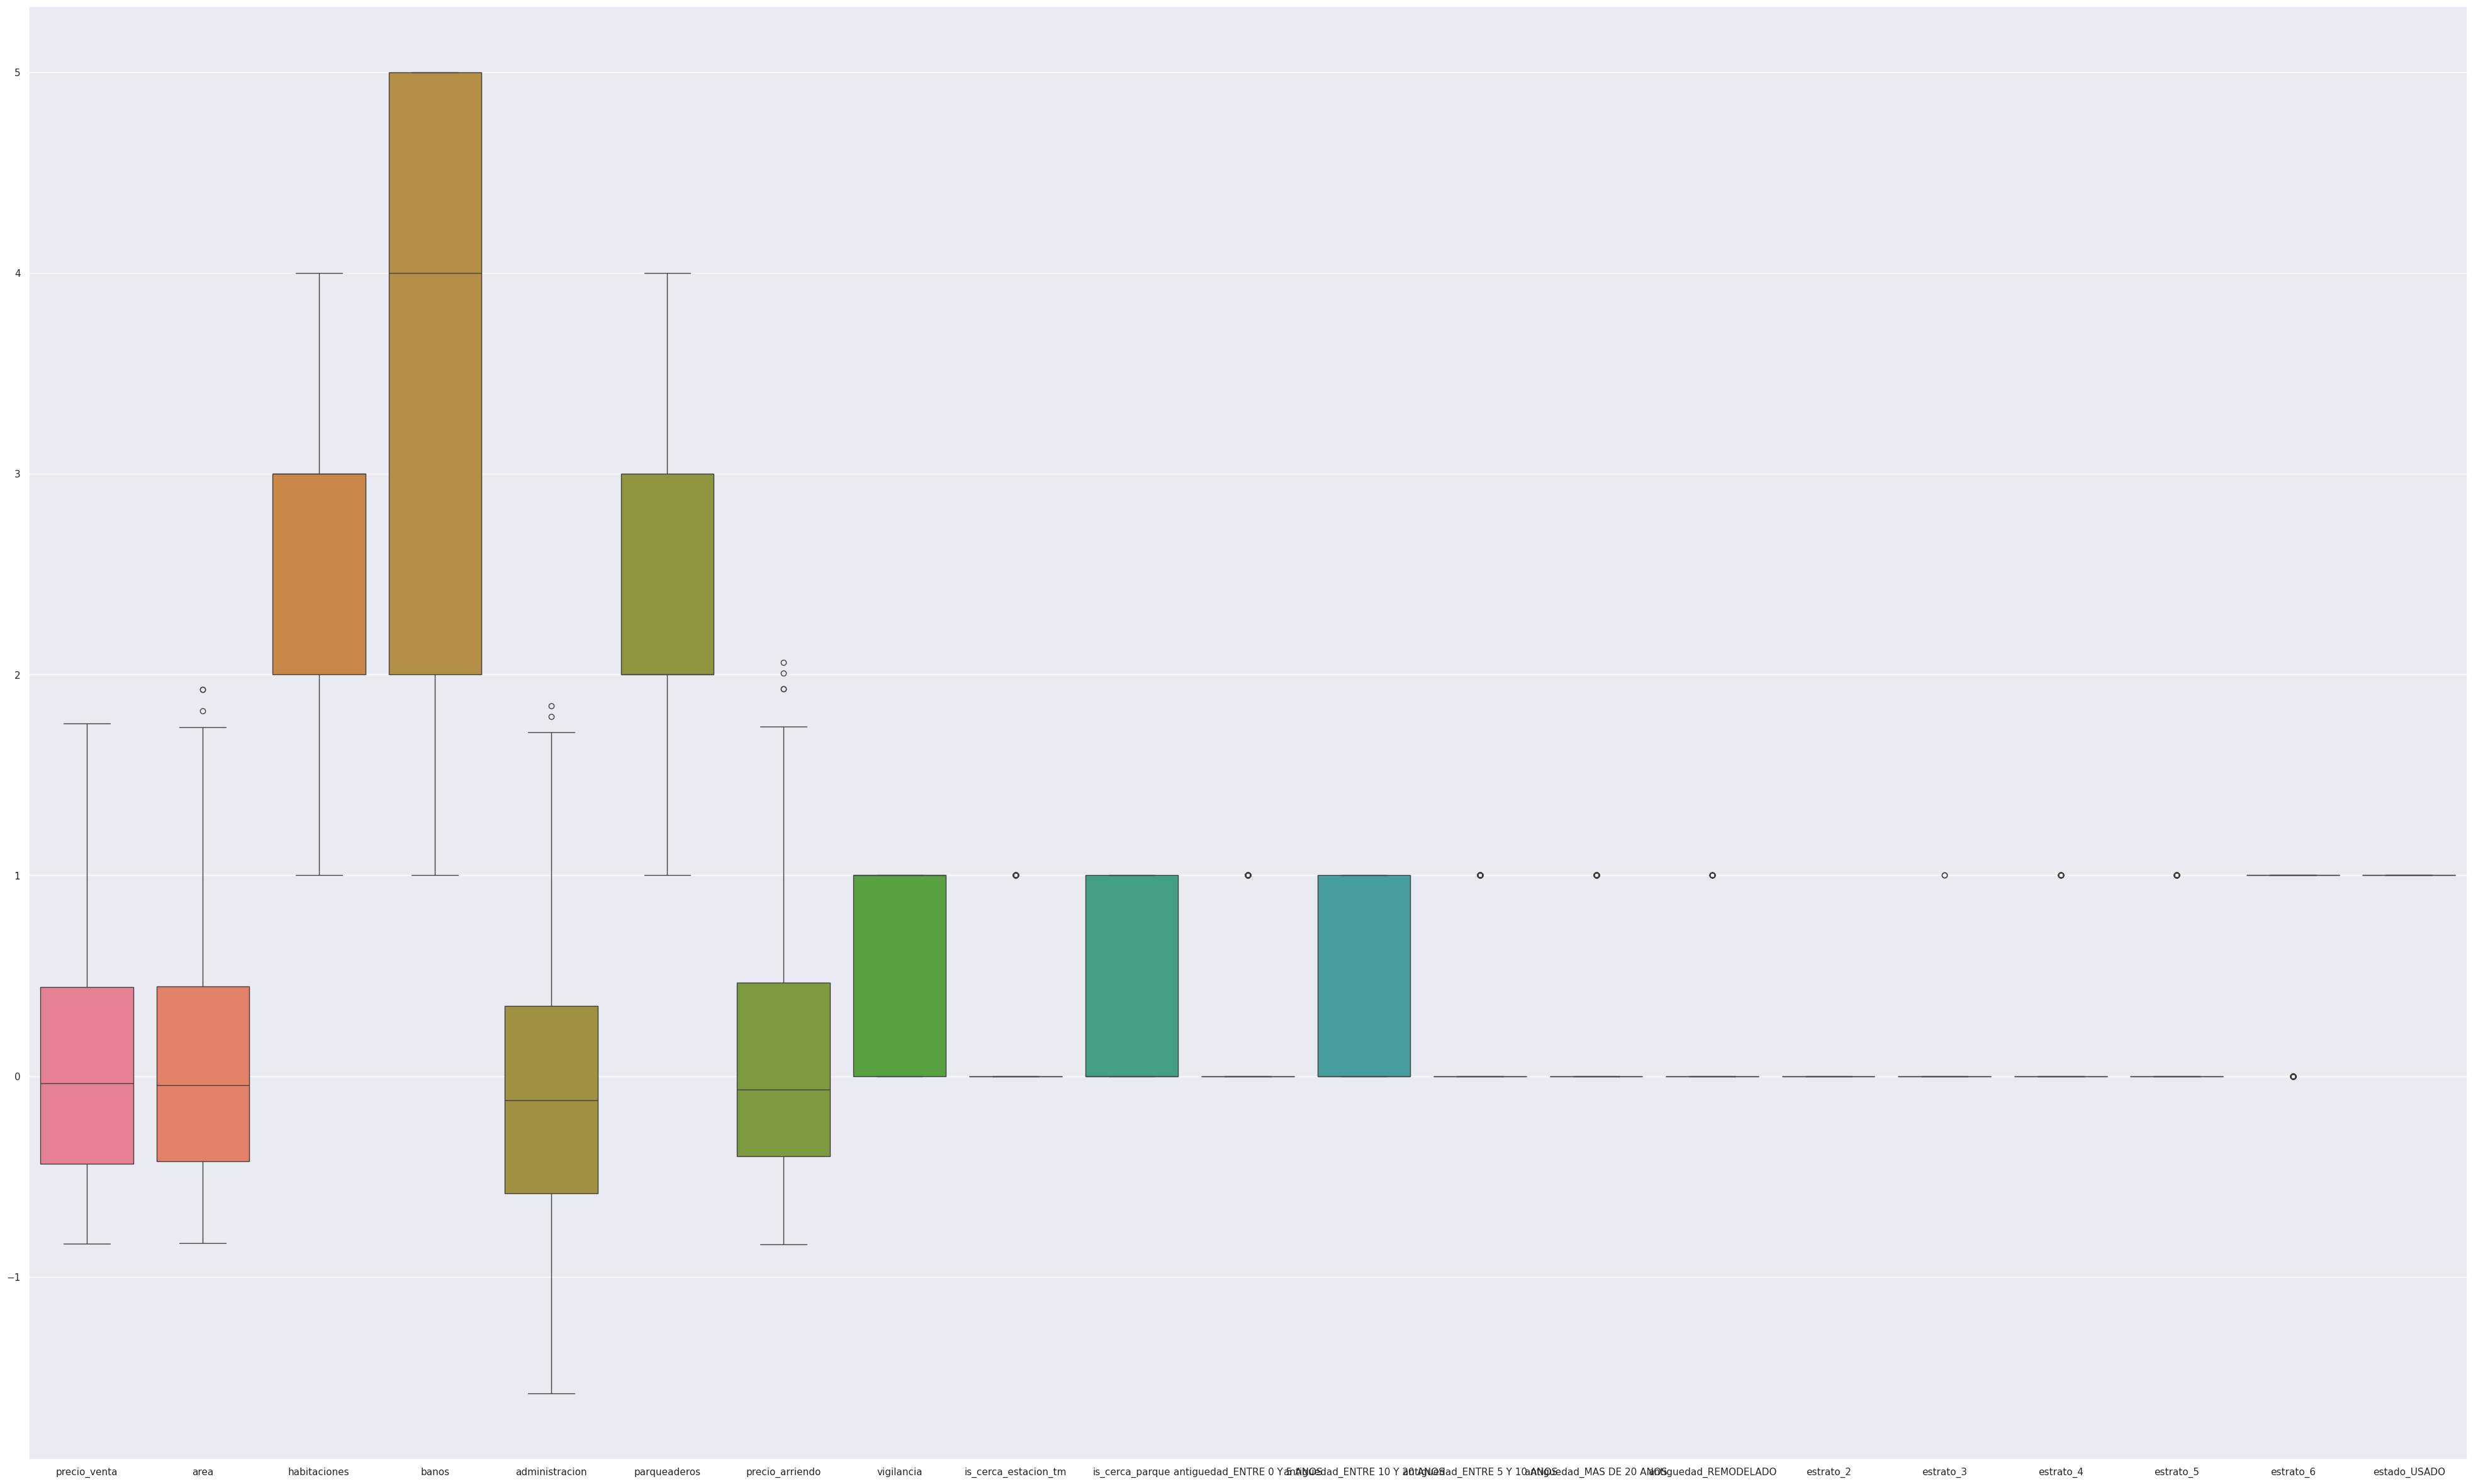

In [ ]:
fig = plt.figure(figsize=(50, 30))
ax = sns.boxplot(data=df_agrupacion, orient="v")
print(">> Se visualizan los datos normalizados: ")
plt.show()

In [ ]:
features2=['precio_venta', 'precio_arriendo', 'area', 'habitaciones', 'banos', 'parqueaderos', 'administracion']
df_agrupacion.head()

,precio_venta,area,habitaciones,banos,administracion,parqueaderos,sector,precio_arriendo,vigilancia,localidad,is_cerca_estacion_tm,is_cerca_parque,antiguedad_ENTRE 0 Y 5 ANOS,antiguedad_ENTRE 10 Y 20 ANOS,antiguedad_ENTRE 5 Y 10 ANOS,antiguedad_MAS DE 20 ANOS,antiguedad_REMODELADO,estrato_2,estrato_3,estrato_4,estrato_5,estrato_6,estado_USADO
0,-0.317003,0.093750,3.0,5.0,-0.401580,2.0,CERROS DE SUBA,-0.345745,1,SUBA,1,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,0.028818,0.068750,3.0,4.0,0.585912,4.0,CHICO,0.000000,1,CHAPINERO,0,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
3,0.172911,0.256250,3.0,5.0,-0.478910,4.0,COUNTRY,-0.265957,1,USAQUEN,0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,0.662824,0.943750,4.0,4.0,0.987492,2.0,COUNTRY,0.066489,1,USAQUEN,0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
5,-0.587896,-0.749375,2.0,2.0,-0.781435,1.0,SANTA BARBARA,-0.518617,0,USAQUEN,0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


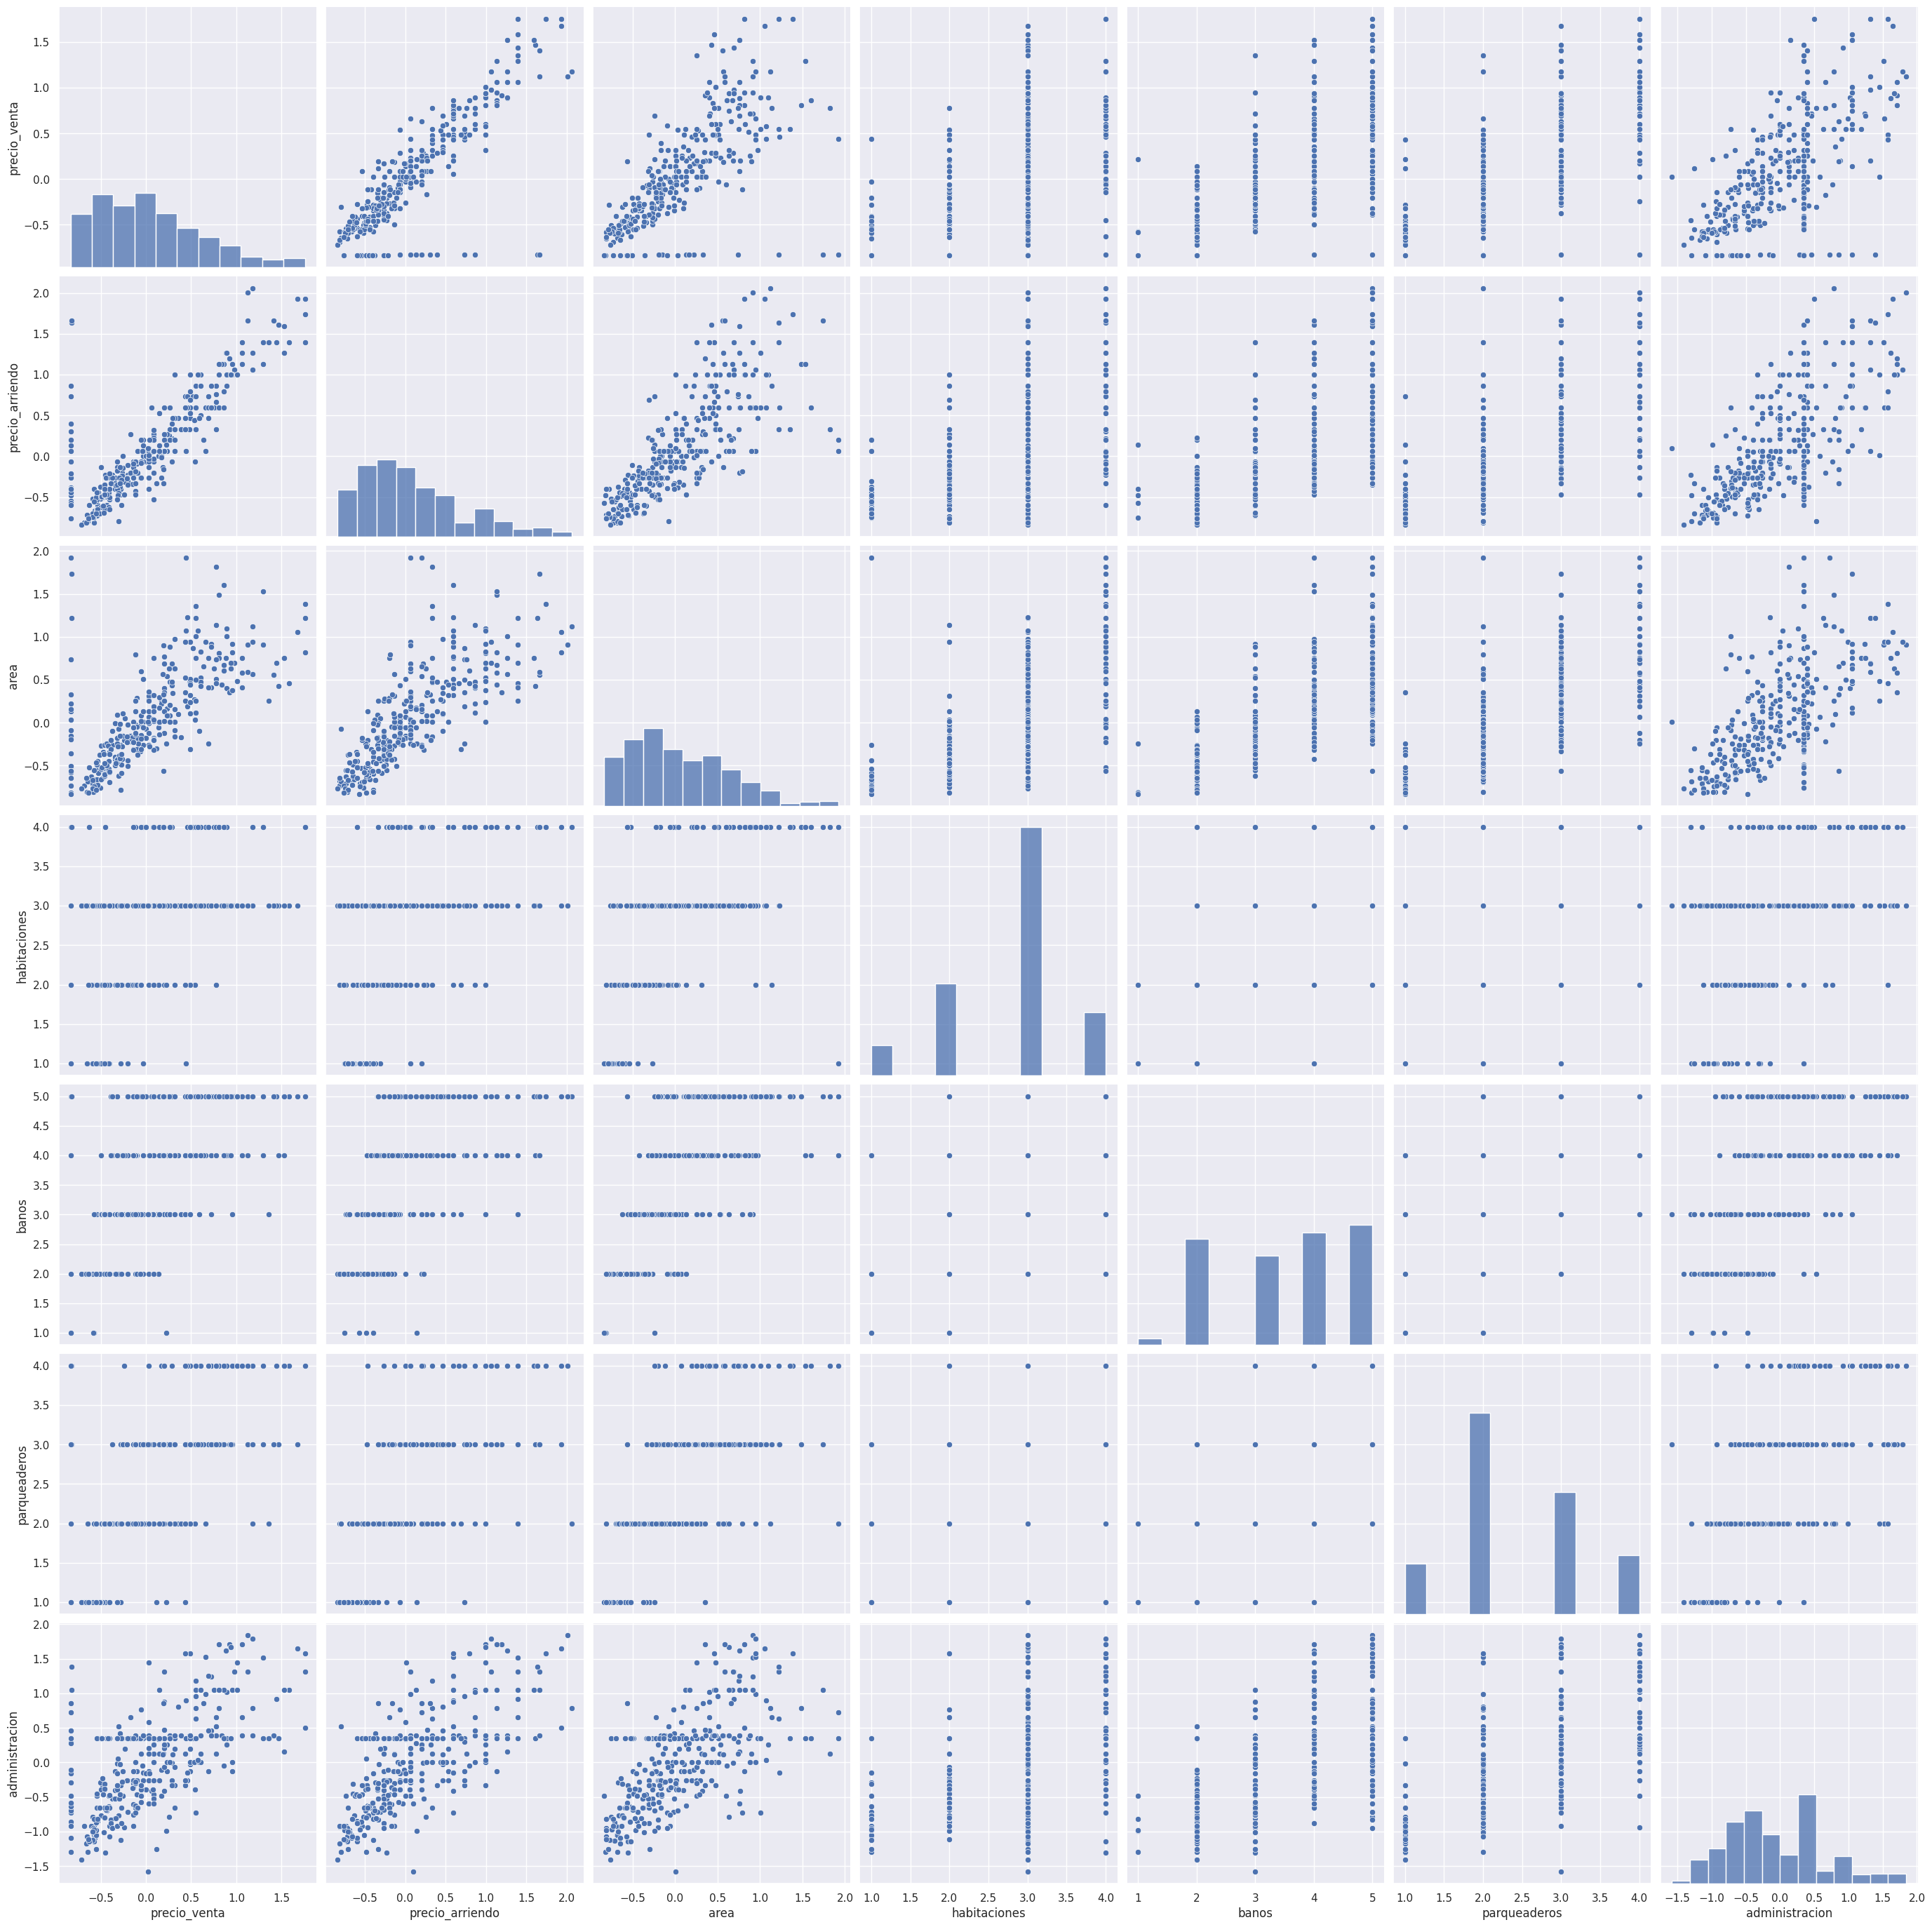

In [ ]:
df_candidatos = df_agrupacion[features2].copy()
sns.pairplot(df_candidatos, height=4, kind='scatter')

Revisando el scatter plot se escogen:

In [ ]:
features_numericas=['precio_venta', 'area', 'precio_arriendo', 'administracion', ]

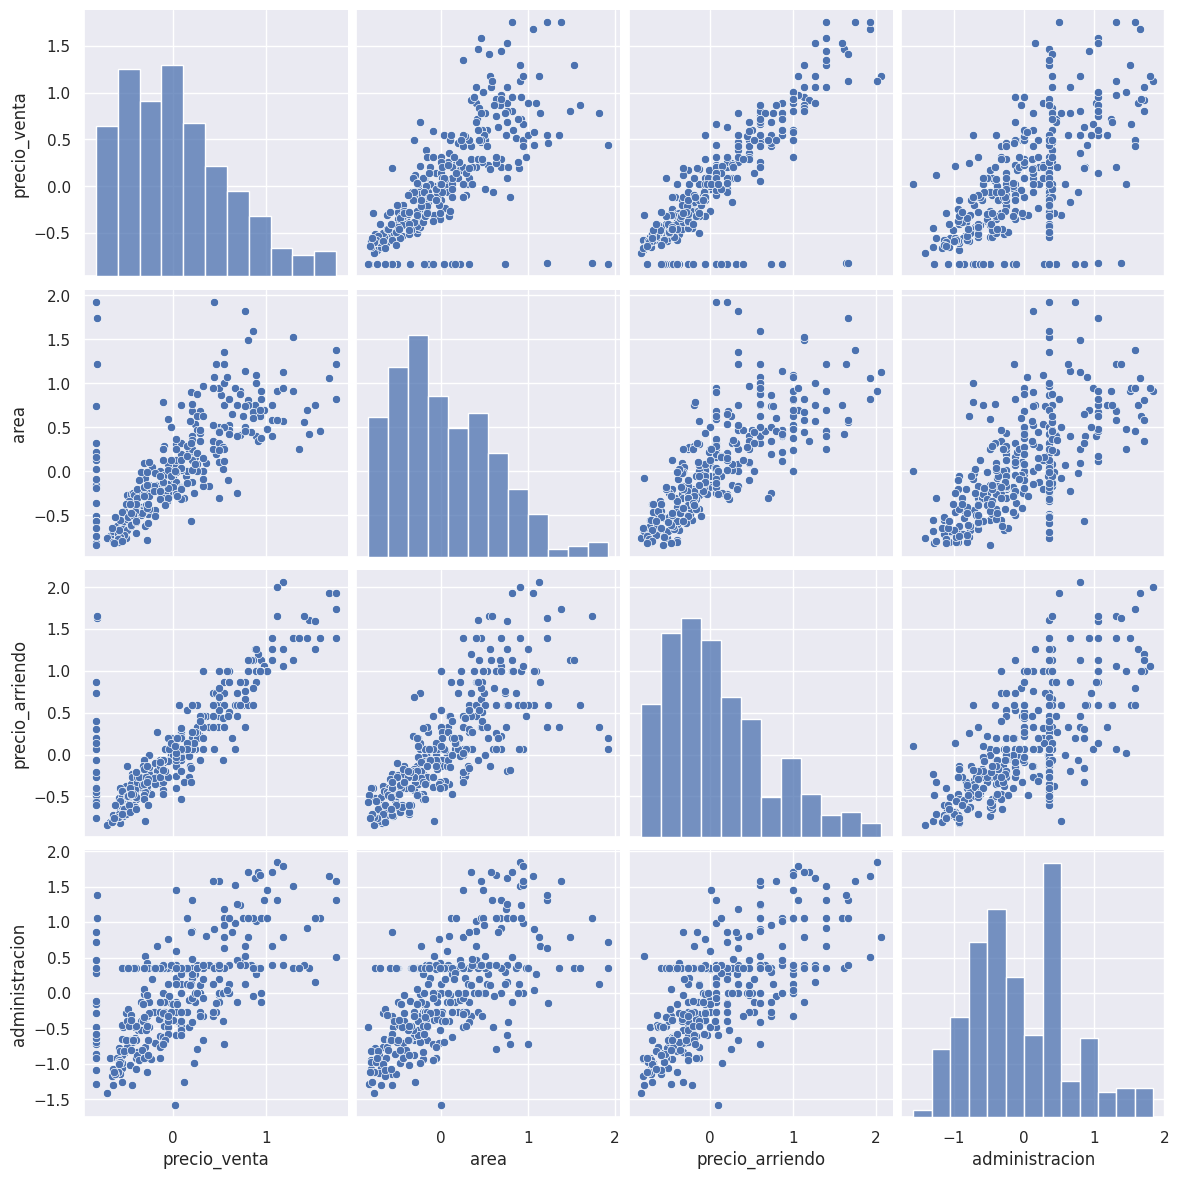

In [ ]:
df_clustering = df_agrupacion[features_numericas].copy()
sns.pairplot(df_clustering, height=3, kind='scatter')

Implementación KMEANs

In [ ]:
#Creamos una función basada en el concepto de silueta
def plot_silhouette(data,
                    labels,
                   ylabel = 'Clústeres',
                   xlabel = "Silhouette coefficient",
                   title = 'Silhouette Plot'):
    '''
    Graficar la silueta de los clusters

    Parametros
    ----------
    data : np.array
        El arreglo con los datos
    labels : np.array
        El arreglo con las etiquetas correspondientes
    ylabel  string
        La etiqueta del eje y
    xlabel : string
        La etiqueta del eje x
    title : string
        El titulo de la gráfica
    '''
    cluster_labels = np.unique(labels)
    print(cluster_labels)
    n_clusters = cluster_labels.shape[0]
    silhouette_vals = silhouette_samples(data,
                                        labels,
                                        metric='euclidean')
    y_ax_lower, y_ax_upper = 0, 0
    yticks = []
    for i, c in enumerate(cluster_labels):
        c_silhouette_vals = silhouette_vals[labels == c]
        c_silhouette_vals.sort()
        y_ax_upper += len(c_silhouette_vals)
        color = cm.jet(float(i) / n_clusters)
        plt.barh(range(y_ax_lower, y_ax_upper),
                        c_silhouette_vals,
                        height=1.0,
                        edgecolor='none',
                        color=color)
        yticks.append((y_ax_lower + y_ax_upper) / 2.)
        y_ax_lower += len(c_silhouette_vals)
    silhouette_avg = np.mean(silhouette_vals)
    plt.axvline(silhouette_avg,
                color="red",
                linestyle="--")
    plt.yticks(yticks, cluster_labels+1)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.title(title)
    plt.show()

    print("\nEl coeficiente de silueta promedio es:", silhouette_avg)

In [ ]:
df_clustering.shape
df_kmeans = df_clustering.copy()

### Configuración de los Hiperparámetros

Los hiperparámetros utilizados para K-Means son los siguientes:

* `n_clusters`: Especifica el número de clusters (K) que se desea formar. Este es uno de los parámetros clave del algoritmo, ya que determina cuántos grupos distintos se buscarán en los datos. El valor de i es variable en este caso, nuestra clase buscará el óptimo al maximizar el coeficiente de silueta promedio.

* `init='random'`: Define el método para inicializar los centroides. En este caso, 'random' selecciona de manera aleatoria los centroides iniciales.

* `max_iter=300`: Establece el número máximo de iteraciones que el algoritmo ejecutará durante el proceso de ajuste. Si los centroides dejan de cambiar antes de llegar a este límite, el algoritmo se detendrá. Si no se alcanza una convergencia, el algoritmo continuará hasta completar las 300 iteraciones.

* `n_init=10`: Indica cuántas veces se ejecutará el algoritmo KMeans con diferentes inicializaciones de los centroides. El modelo selecciona el resultado con la mejor inercia (menor suma de distancias al cuadrado dentro de los clusters). Con n_init=10, se ejecutarán 10 rondas de K-Means, lo que ayuda a obtener una mejor solución y evitar quedar atrapado en mínimos locales.

* `random_state=777`: Fija una semilla aleatoria para garantizar que los resultados sean reproducibles. Esto asegura que las inicializaciones aleatorias sean las mismas en cada ejecución, lo cual es útil para obtener resultados consistentes en experimentos o comparaciones.

Se emplea el dataframe con los datos candidatos (incluyendo los que fueron seleccionados tras la codificación OneHot), pero eliminando las categorías asociadas a Sexo para permitir el análsis sobre una muestra más pura de datos numéricos y sólo dependiente del Grupo.

Para seleccionar la cantidad de clústers iniciales, utilizamos el Método del Codo.

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
def plot_distortion(data, k_min=1, k_max=11, ylabel = 'Distortion', xlabel = 'Number of clusters', title = 'Distortion Plot'):
    '''
    Graficar el codo de los clusters
    '''
    distortions = []
    for i in range(k_min, k_max):
        km = KMeans(n_clusters=i,
                 init='k-means++',
                 n_init=10,
                 max_iter=300,
                 random_state=0)
        km.fit(data)
        distortions.append(km.inertia_)
    plt.plot(range(k_min,k_max), distortions, marker='o')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

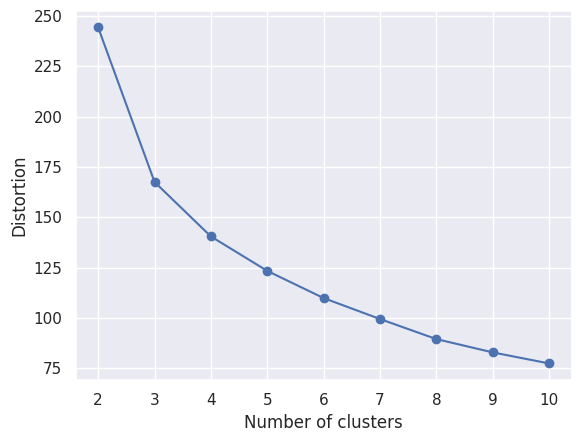

In [ ]:
plot_distortion(df_kmeans, 2, 11)

Se complementa el análisis con el Método de la Silueta.

In [ ]:
def plot_selectK_silhoute(data, k_min=1, k_max=11, ylabel = 'Silhouette Coefficient', xlabel = 'Number of clusters'):
    '''
    Graficar el codo de los clusters
    '''
    # Crear una lista para almacenar los coeficientes de la silueta para cada valor de k analizado

    silhouette_coefficients = []

    # Notice you start at 2 clusters for silhouette coefficient
    for k in range(k_min, k_max):
        kmeans = KMeans(n_clusters=k, init='random', max_iter=300, n_init=10, random_state=777)
        kmeans.fit(data)
        score = silhouette_score(data, kmeans.labels_)
        silhouette_coefficients.append(score)
    plt.plot(range(k_min, k_max), silhouette_coefficients)
    plt.xticks(range(k_min, k_max))
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

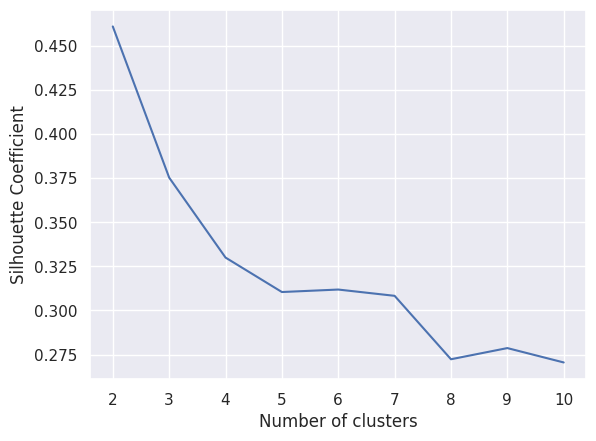

In [ ]:
plot_selectK_silhoute(df_kmeans, 2, 11)

Como no se puede apreciar con total claridad un punto de inflexión en la gráfica del Método del Codo, se decidió realizar una aproximación práctica entre los valores del número de clústers k. Como no existe GridSearch para algoritmos de clustering, se creó un objeto similar cuya función es buscar el parámetro k que genera el mayor coeficiente de silueta.

In [ ]:
class KMeans_Silhouette:
  def __init__(self, data, k_min=2, k_max=11):
      # Recibe los datos y define un k mínimo y un k máximo para definir el espacio de búsqueda
      self.data = data
      self.k_min = k_min
      self.k_max = k_max
      self.best_k = None
      self.best_model = None

  def fit(self):
      # Almacenar todos los coeficientes de silueta promedio
      self.silhouette_scores = []
      self.models = []

      # Iterar entre el mínimo y el máximo
      for i in range(self.k_min, self.k_max):
          # Crear un KMeans por cada valor de k
          km = KMeans(n_clusters=i, init='random', max_iter=300, n_init=10, random_state=777)
          # Entrenar los modelos
          res = km.fit(self.data)
          # Almacenar los modelos
          self.models.append(res)
          # Obtener los labels de la clasificación actual
          labels = km.labels_
          silhouette_avg = silhouette_score(self.data, labels)

          self.silhouette_scores.append(silhouette_avg)

      self.best_k = np.argmax(self.silhouette_scores) + self.k_min
      self.best_model = self.models[self.best_k - self.k_min]
      return self.best_k, self.best_model


In [ ]:
kmeans_searcher = KMeans_Silhouette(df_kmeans, 3, 6)
kmeans_searcher.fit()

print("El número de clusters k es:", kmeans_searcher.best_k)
res_kmeans = kmeans_searcher.best_model

El número de clusters k es: 3


A partir del mejor modelo en términos del coeficiente de silueta (que, de hecho, confirma el resultado de la gráfica del Método de la Silueta), se continúa con el análisis para tres clústers.

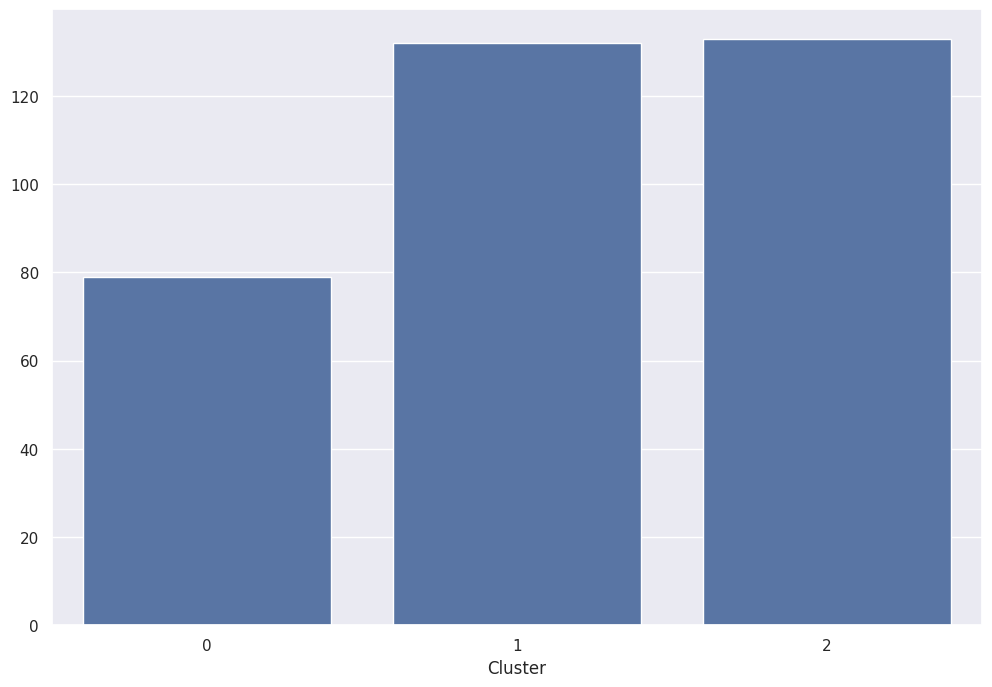

In [ ]:
# Revisar la cantidad de registros en los clústeres resultado
labels = res_kmeans.labels_
df_kmeans['Cluster'] = labels
cluster_distrib = df_kmeans['Cluster'].value_counts()
fig=plt.figure(figsize=(12,8))
sns.barplot(x=cluster_distrib.index, y=cluster_distrib.values, color='b');

Se genera una tabla que resume los valores exactos de la cantidad de elementos del conjunto de datos clasificados, mostrado en el gráfico de barras anterior. Se puede apreciar de antemano que la división parece coherente y útil debido a que los datos en las tres categorías están balanceados, todos están en torno a los 300 datos, sólo con el primer clúster un poco rezagado.

In [ ]:
# Revisar el número exacto de elementos por clúster y las variables utilizadas.
df_kmeans.groupby('Cluster').count()

,precio_venta,area,precio_arriendo,administracion
Cluster,,,,
0,79,79,79,79
1,132,132,132,132
2,133,133,133,133


Utilizamos las columnas numéricas para cruzarlas entre sí y poder obtener una visualización más clara de las relaciones entre los grupos generados y las parejas de features numéricos.

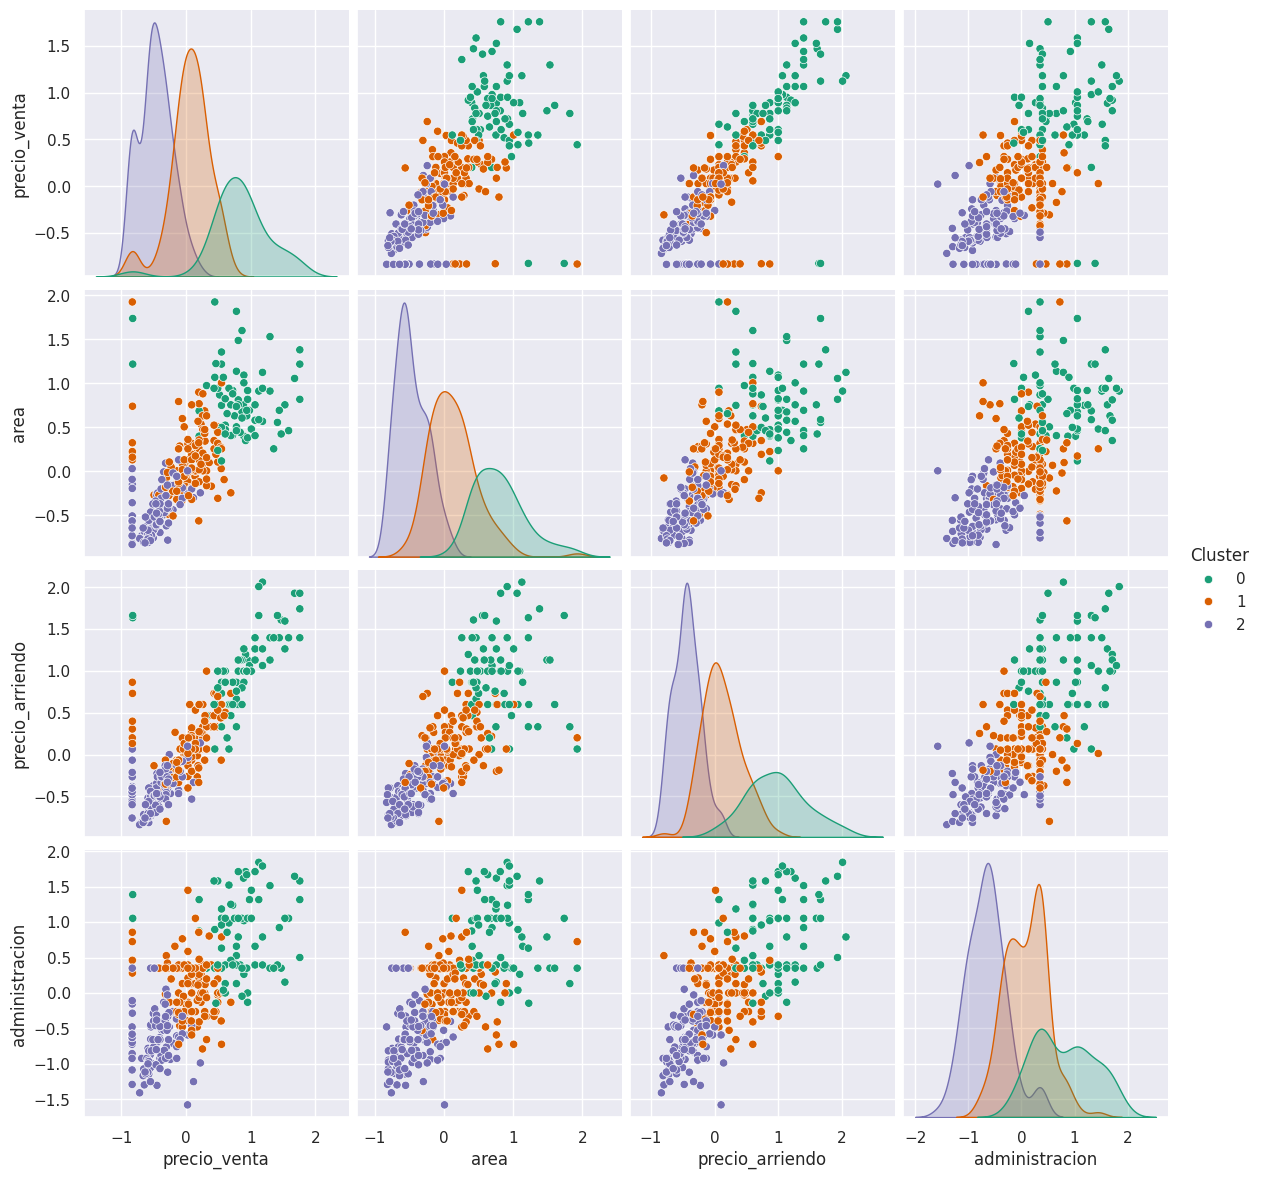

In [ ]:
# El análisis de la gráfica es más dificil ya que son más columnas.
# Ajustar la paleta de colores para ver mejor
sns.pairplot(data=df_kmeans[features_numericas + ['Cluster']], height=3, hue="Cluster", palette="Dark2")

Se puede apreciar que la pareja que mejor permite visualizar los clusters es Duracion_KTAS_Min vs. Edad, pues se puede apreciar de forma más clara la distinción entre todos los grupos generados.

El siguiente análisis se realiza con dicha pareja. Se busca generar la misma gráfica en mayor detalle, destacando a qué grupo pertenece cada uno de los registros. Adicionalmente, en la siguiente gráfica se ubican los centroides de cada uno de los grupos generados por K-Means.

In [ ]:
cols_number = df_kmeans[features_numericas + ['Cluster']].to_numpy()

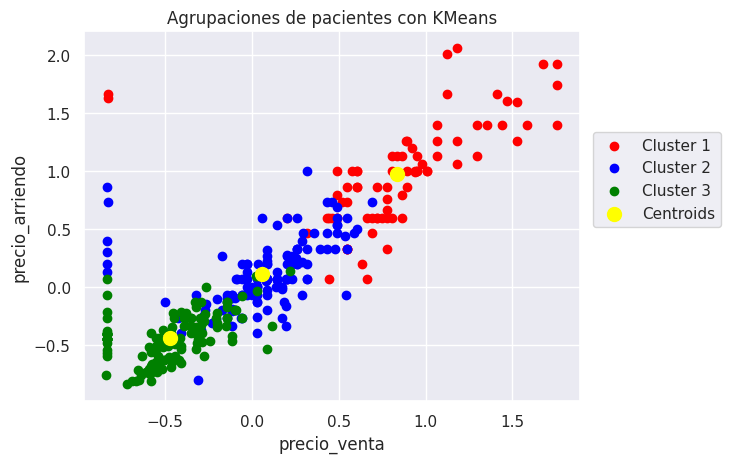

In [ ]:
# El análisis lo haremos por pareja de atributos, en este caso
plt.scatter(cols_number[res_kmeans.labels_ == 0, 0], cols_number[res_kmeans.labels_ == 0, 2], c = 'red', label = 'Cluster 1')
plt.scatter(cols_number[res_kmeans.labels_ == 1, 0], cols_number[res_kmeans.labels_ == 1, 2], c = 'blue', label = 'Cluster 2')
plt.scatter(cols_number[res_kmeans.labels_ == 2, 0], cols_number[res_kmeans.labels_ == 2, 2], c = 'green', label = 'Cluster 3')

plt.scatter(res_kmeans.cluster_centers_[:, 0], res_kmeans.cluster_centers_[:, 2], s = 100, c = 'yellow', label = 'Centroids')
plt.title('Agrupaciones de pacientes con KMeans')
plt.xlabel(df_kmeans.columns[0])
plt.ylabel(df_kmeans.columns[2])
plt.legend(bbox_to_anchor = (1.3, 0.6), loc='center right')
plt.show()

Se crea, finalmente, una gráfica que permite visualizar los coeficientes de silueta de todos los datos, una distribución de la cantidad de datos en cada grupo y el cálculo del coeficiente de silueta promedio de todos los datos.

[0 1 2]


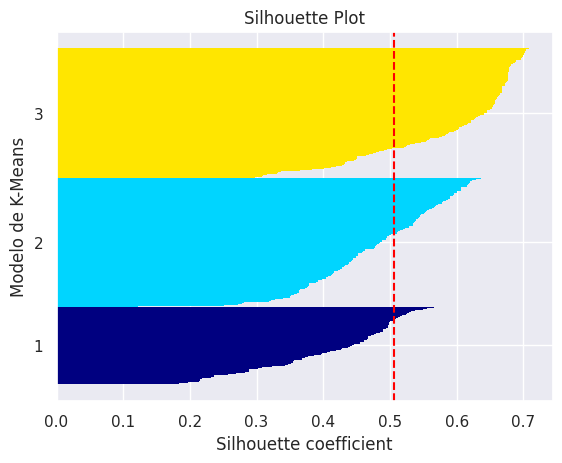


El coeficiente de silueta promedio es: 0.506026961011907


In [ ]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import matplotlib.cm as cm
plot_silhouette(data = df_kmeans,
                labels = labels,
                ylabel = 'Modelo de K-Means')

Como podemos apreciar, el coeficiente de silueta promedio es de 0.5 aproximadamente. El coeficiente de silueta mide cuán bien se asignan los puntos a sus respectivos clusters, comparando la distancia intra-cluster (dentro de un mismo grupo) con la distancia inter-cluster (con otros grupos).

En este orden de ideas, un valor promedio de 0.5 sugiere que las muestras están, en general, muy bien asignadas, con relativas separaciones entre los clusters. Además, se puede apreciar que para aproximadamente más de la mitad de los datos (más precisamente en 2 de los 3 grupos), el coeficiente de silueta se encuentra por encima de la media. Esto indica que el número de clusters seleccionado (3) es probablemente adecuado para los datos, y la estructura de los grupos está bien definida.